# Deep Learning - LSTM


## Importing required libraries and data

In [1]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.3/123.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

np.random.seed(46)
path = '/content/final_df.csv'
from sdv.metadata import SingleTableMetadata
from sdv.sequential import PARSynthesizer
from sdmetrics.reports import utils
import sdmetrics
from sdmetrics.reports.single_table import DiagnosticReport
from sdmetrics.reports.single_table import QualityReport

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix, classification_report

Here I select only the rows related to the protocol states referring to baseline and stress experiment, in order to perform a binary classification.

In [4]:
dataset = pd.read_csv(path)
protocol_states = ['Base', 'TSST']
dataset = dataset[dataset['labels'].isin(protocol_states)]
mapping_dict = {'Base': 0,
                'TSST': 1}
dataset['labels'] = dataset['labels'].map(mapping_dict)
dataset.head()

,ID,Time,hr,temp,labels
420,0,2023-07-13 00:07:00,75.563333,35.447233,0
421,0,2023-07-13 00:07:01,75.570000,35.549821,0
422,0,2023-07-13 00:07:02,75.573333,35.449041,0
423,0,2023-07-13 00:07:03,75.593333,35.543187,0
424,0,2023-07-13 00:07:04,75.643333,35.443003,0


Apply a min-max scaler on the signals only

In [5]:
scaler = MinMaxScaler()
columns_to_scale = ['hr', 'temp']
scaled_df = dataset.copy(deep=True)
scaled_df[['hr', 'temp']] = scaler.fit_transform(scaled_df[['hr', 'temp']])
scaled_df.head()

,ID,Time,hr,temp,labels
420,0,2023-07-13 00:07:00,0.385214,0.931318,0
421,0,2023-07-13 00:07:01,0.385324,0.944449,0
422,0,2023-07-13 00:07:02,0.385379,0.931549,0
423,0,2023-07-13 00:07:03,0.385708,0.943600,0
424,0,2023-07-13 00:07:04,0.386531,0.930776,0


In [6]:
scaled_df.tail()

,ID,Time,hr,temp,labels
104079,14,2023-07-13 01:12:55,0.308709,0.525045,1
104080,14,2023-07-13 01:12:56,0.308874,0.526190,1
104081,14,2023-07-13 01:12:57,0.309038,0.524747,1
104082,14,2023-07-13 01:12:58,0.309312,0.526173,1
104083,14,2023-07-13 01:12:59,0.309696,0.525708,1


## Data Augmentation

In [10]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=scaled_df)
metadata.update_column(column_name='ID', sdtype='id')
metadata.update_column(column_name='Time', sdtype='datetime', datetime_format='%Y-%m-%d %H:%M:%S')
metadata.set_sequence_key(column_name='ID')

In [11]:
synthesizer = PARSynthesizer(metadata, verbose=True, enforce_min_max_values=True, enforce_rounding=True, epochs = 1000)

In [12]:
synthesizer.fit(scaled_df)

Epoch 1000 | Loss -51.24332809448242: 100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


In [13]:
synthesizer.save(filepath='synthesizer.pkl')
#synthesizer = PARSynthesizer.load(filepath='my_synthesizer.pkl')

In [14]:
synthetic_data = synthesizer.sample(num_sequences=10)

100%|██████████| 10/10 [02:47<00:00, 16.73s/it]


In [15]:
synthetic_data.to_csv('synthetic_data.csv')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


### Evaluation of synthetic data

In [16]:
synthetic_data.head()

,ID,Time,hr,temp,labels
0,0,2023-07-13 00:06:46,0.557375,0.514671,0
1,0,2023-07-13 00:04:46,0.490132,0.488875,0
2,0,2023-07-13 00:06:05,0.787061,0.433814,0
3,0,2023-07-13 00:05:11,0.547956,0.446066,0
4,0,2023-07-13 00:04:23,0.524238,0.414638,0


In [17]:
synthetic_data.tail()

,ID,Time,hr,temp,labels
19586,9,2023-07-13 00:40:04,0.219590,0.336227,1
19587,9,2023-07-13 00:53:37,0.313679,0.323963,1
19588,9,2023-07-13 00:41:55,0.285399,0.377074,1
19589,9,2023-07-13 00:48:32,0.328290,0.369435,1
19590,9,2023-07-13 00:42:31,0.519213,0.384081,1


In [18]:
meta_dict = metadata.to_dict()

In [19]:
report = DiagnosticReport()
report.generate(scaled_df, synthetic_data, meta_dict)

Creating report: 100%|██████████| 4/4 [00:52<00:00, 13.21s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! More than 10% of the synthetic rows are copies of the real data


In [20]:
report.get_properties()

{'Coverage': 1.0, 'Synthesis': 0.8058, 'Boundaries': 0.991565004338727}

In [21]:
report = QualityReport()
report.generate(scaled_df, synthetic_data, meta_dict)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]


Overall Quality Score: 70.29%

Properties:
Column Shapes: 60.35%
Column Pair Trends: 80.23%


In [22]:
round(report.get_score(), 2)

0.7

#### Synthetic Visualization

In [23]:
fig = utils.get_column_plot(
    real_data=scaled_df,
    synthetic_data=synthetic_data,
    column_name='hr',
    metadata=meta_dict
)

fig.show()

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<froz

In [24]:
fig = utils.get_column_plot(
    real_data=scaled_df,
    synthetic_data=synthetic_data,
    column_name='temp',
    metadata=meta_dict
)

fig.show()

In [25]:
fig = utils.get_column_pair_plot(
    real_data=scaled_df,
    synthetic_data=synthetic_data,
    column_names=['hr', 'temp'],
    metadata=meta_dict

)

fig.show()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_modul

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



## Data Preprocessing

In [26]:
synthetic_data['ID'] = synthetic_data['ID'] + 15

In [27]:
df = pd.concat([scaled_df, synthetic_data], ignore_index=True)

In [28]:
df.head()

,ID,Time,hr,temp,labels
0,0,2023-07-13 00:07:00,0.385214,0.931318,0
1,0,2023-07-13 00:07:01,0.385324,0.944449,0
2,0,2023-07-13 00:07:02,0.385379,0.931549,0
3,0,2023-07-13 00:07:03,0.385708,0.943600,0
4,0,2023-07-13 00:07:04,0.386531,0.930776,0


In [29]:
df.tail()

,ID,Time,hr,temp,labels
49586,24,2023-07-13 00:40:04,0.219590,0.336227,1
49587,24,2023-07-13 00:53:37,0.313679,0.323963,1
49588,24,2023-07-13 00:41:55,0.285399,0.377074,1
49589,24,2023-07-13 00:48:32,0.328290,0.369435,1
49590,24,2023-07-13 00:42:31,0.519213,0.384081,1


In [30]:
# Extract the individual IDs from the dataset
individual_ids = df['ID'].unique()

# Find the maximum sequence length
max_length = df.groupby('ID').size().max()

# Pad sequences to the maximum length
padded_sequences = []
for person in individual_ids:
    person_data = df[df['ID'] == person][['hr', 'temp', 'labels', 'ID']].values
    padded_sequence = pad_sequences([person_data], maxlen=max_length, dtype='float32', padding='post')
    padded_sequences.append(padded_sequence[0])

reshaped_data = np.array(padded_sequences)

# Check the shape of the reshaped data
print(reshaped_data.shape)

(25, 2100, 4)


In [31]:
data = reshaped_data[:, :, :-2]
labels = reshaped_data[:, :, -2]
group = reshaped_data[:, :, -1]

## Model

In [36]:
def build_model():
    # Define the input layer
    input_data = Input(shape=(max_length, 2))

    # Define the LSTM layer
    lstm_output = LSTM(16, dropout = 0.2, return_sequences=True)(input_data)

    # Define the output layer
    output = Dense(1, activation='sigmoid', trainable = True)(lstm_output)

    # Create and return the model
    model = Model(inputs=input_data, outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    return model

In [37]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2100, 2)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 2100, 16)          1216      
                                                                 
 dense_1 (Dense)             (None, 2100, 1)           17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


In [38]:
cv = KFold(n_splits=25)

In [39]:
auc_scores = []
history_train_losses = []
history_val_losses = []
for i, (train_index, test_index) in enumerate(cv.split(data, labels, group)):
  print(f"Fold {i}:")
  X_train, X_test, y_train, y_test = data[train_index], data[test_index], labels[train_index], labels[test_index]

  history = model.fit(X_train, y_train, epochs=30, validation_data = (X_test, y_test), batch_size=1, verbose=2)

  history_train_losses.append(history.history['loss'])
  history_val_losses.append(history.history['val_loss'])

  _, auc = model.evaluate(X_test, y_test)
  auc_scores.append(auc)

Fold 0:
Epoch 1/30


<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



24/24 - 3s - loss: 0.6965 - auc: 0.4763 - val_loss: 0.6966 - val_auc: 0.7605 - 3s/epoch - 137ms/step
Epoch 2/30
24/24 - 1s - loss: 0.6906 - auc: 0.4895 - val_loss: 0.7190 - val_auc: 0.7994 - 1s/epoch - 42ms/step
Epoch 3/30
24/24 - 1s - loss: 0.6885 - auc: 0.5052 - val_loss: 0.7368 - val_auc: 0.8951 - 980ms/epoch - 41ms/step
Epoch 4/30
24/24 - 1s - loss: 0.6865 - auc: 0.5402 - val_loss: 0.7301 - val_auc: 0.9264 - 990ms/epoch - 41ms/step
Epoch 5/30
24/24 - 1s - loss: 0.6851 - auc: 0.5634 - val_loss: 0.7383 - val_auc: 0.9015 - 1s/epoch - 42ms/step
Epoch 6/30
24/24 - 1s - loss: 0.6871 - auc: 0.5244 - val_loss: 0.7536 - val_auc: 0.9287 - 1s/epoch - 60ms/step
Epoch 7/30
24/24 - 2s - loss: 0.6835 - auc: 0.5721 - val_loss: 0.7418 - val_auc: 0.9372 - 2s/epoch - 64ms/step
Epoch 8/30
24/24 - 1s - loss: 0.6839 - auc: 0.5575 - val_loss: 0.7565 - val_auc: 0.9459 - 1s/epoch - 50ms/step
Epoch 9/30
24/24 - 1s - loss: 0.6779 - auc: 0.6092 - val_loss: 0.7118 - val_auc: 0.9526 - 998ms/epoch - 42ms/step
Ep

## Evaluating

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



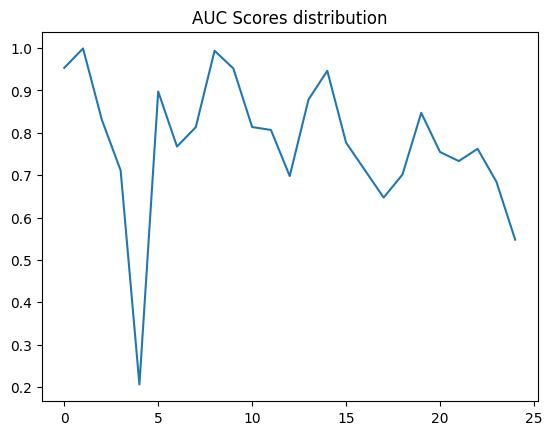

In [40]:
plt.plot(auc_scores)
plt.title('AUC Scores distribution')
plt.show()

In [41]:
import statistics
print(round(statistics.mean(auc_scores),2))
print(round(statistics.stdev(auc_scores),2))


0.78
0.16


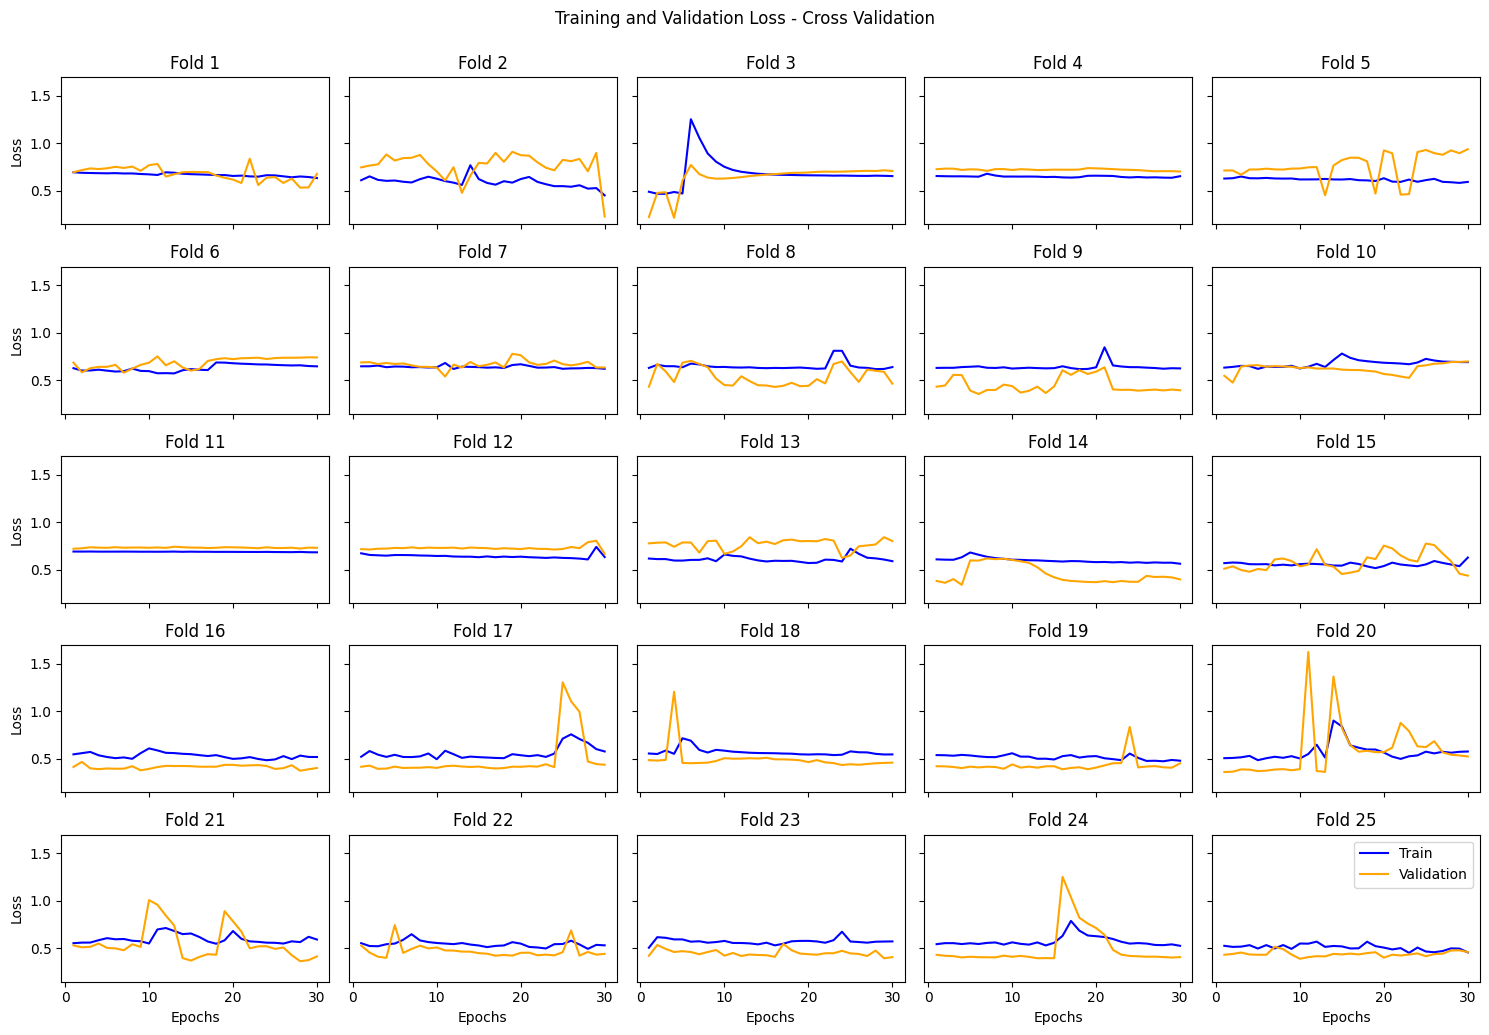

In [62]:
import matplotlib.pyplot as plt

num_folds = len(history_train_losses)
rows = 5  # Number of rows in the grid
cols = 5  # Number of columns in the grid

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)

for i in range(num_folds):
    row = i // cols
    col = i % cols

    train_loss = history_train_losses[i]
    val_loss = history_val_losses[i]
    epochs = range(1, len(train_loss) + 1)

    # Plot the training and validation loss in the current subplot
    axes[row, col].plot(epochs, train_loss, color='blue', label="Train")
    axes[row, col].plot(epochs, val_loss, color='orange', label="Validation")
    axes[row, col].set_title(f"Fold {i+1}")

    # Add labels to the outermost subplots
    if row == rows - 1:
        axes[row, col].set_xlabel('Epochs')
    if col == 0:
        axes[row, col].set_ylabel('Loss')

    # Add legend to the last subplot in the last row
    if i == num_folds - 1:
        axes[row, col].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.suptitle('Training and Validation Loss - Cross Validation', y=1.03)
plt.show()

1/1 [==============================] - 0s 451ms/step


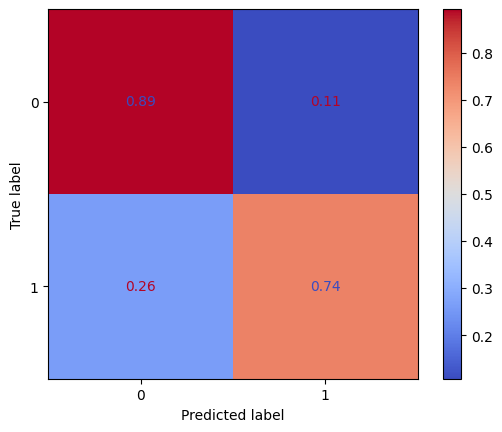

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_probs = model.predict(data)
y_pred_labels = np.round(y_pred_probs).astype(int)  # Round probabilities to 0 or 1

# Flatten the true and predicted labels for confusion matrix calculation
y_true = labels.flatten()
y_pred_labels = y_pred_labels.flatten()

ConfusionMatrixDisplay.from_predictions(y_pred_labels, y_true, normalize='true', cmap='coolwarm')


In [51]:
target_names = ['Baseline', 'Anxiety']
print(classification_report(y_true, y_pred_labels, target_names=target_names))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



              precision    recall  f1-score   support

    Baseline       0.89      0.61      0.72     24093
     Anxiety       0.74      0.94      0.83     28407

    accuracy                           0.79     52500
   macro avg       0.82      0.77      0.78     52500
weighted avg       0.81      0.79      0.78     52500



1/1 [==============================] - 1s 650ms/step


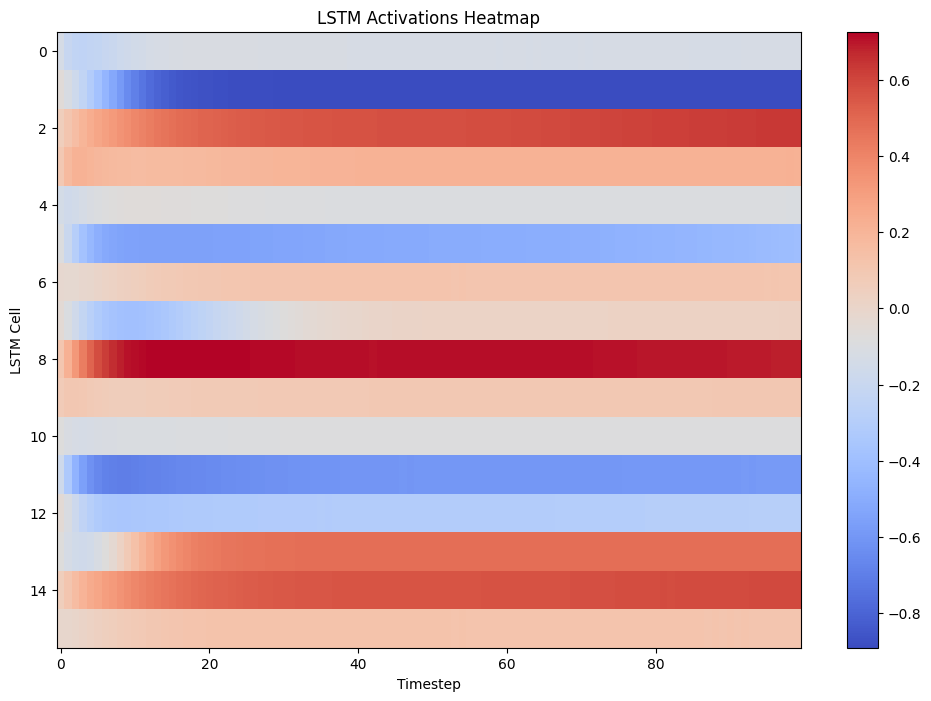

In [59]:
import matplotlib.pyplot as plt

# Function to get the activations of the LSTM layer
def get_lstm_activations(model, data):
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                                     outputs=model.layers[1].output)
    activations = intermediate_layer_model.predict(data)
    return activations

# Get the LSTM activations for the data
lstm_activations = get_lstm_activations(model, data)

# Define the subset of timesteps and LSTM cells to plot
num_timesteps_to_plot = min(100, lstm_activations.shape[1])
num_lstm_cells_to_plot = min(50, lstm_activations.shape[2])

# Plotting the heatmap
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.imshow(lstm_activations[0, :num_timesteps_to_plot, :num_lstm_cells_to_plot].T, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.title('LSTM Activations Heatmap')
plt.xlabel('Timestep')
plt.ylabel('LSTM Cell')
plt.colorbar()
plt.show()

In [60]:
model.save('/content/LSTM')

In [61]:
from google.colab import files
files.download("/content/LSTM")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>